In [66]:
import re
import unicodedata
import pandas as pd
import nltk
import env
from env import get_connection
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import acquire as ac
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

## Spam Data

* Load the spam data set.
* Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
* Is there any overlap in the bigrams for the spam data and the ham data?
* Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [8]:
url = get_connection("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [10]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


,n,percent
ham,4825,0.865937
spam,747,0.134063


In [11]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [14]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [15]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [17]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [18]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

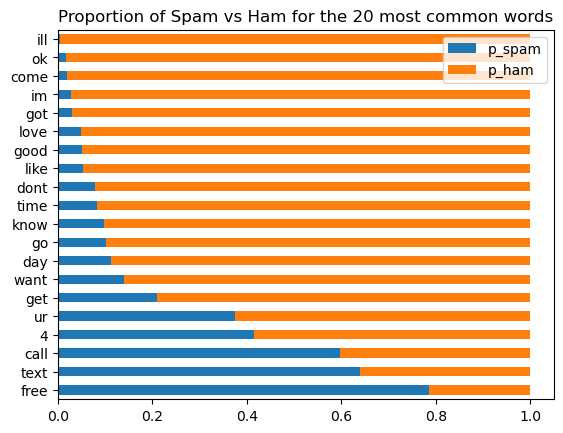

In [20]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [21]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


## wordcloud

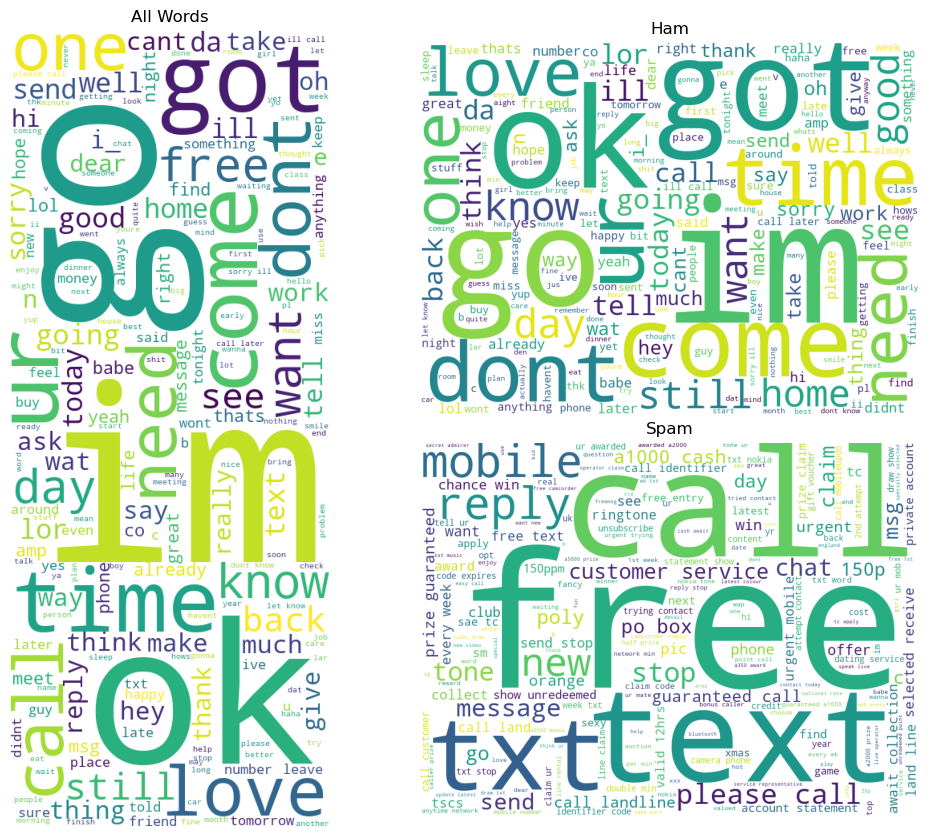

In [23]:
from wordcloud import WordCloud
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

## bigrams and trigrams

In [24]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

In [25]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

In [26]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
dtype: int64

In [115]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

# Explore the blog articles using the techniques discussed in the exploration lesson.



In [39]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()

    string= tokenizer.tokenize(string, return_str=True)
    return string

In [80]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [92]:
codeup_df=ac.get_blog_articles()
codeup_df=pd.DataFrame(codeup_df)

In [93]:
codeup_df.head()

,title,date_published,content
0,Coding Bootcamp or Self-Learning? Which is Bes...,"Jan 20, 2023",\nIf you’re interested in embarking on a caree...
1,Codeup Among Top 58 Best Coding Bootcamps of 2023,"Jan 12, 2023",\nCodeup is pleased to announce we have been r...
2,Black excellence in tech: Panelist Spotlight –...,"Feb 6, 2023",\nBlack excellence in tech: Panelist Spotlight...
3,Black excellence in tech: Panelist Spotlight –...,"Feb 10, 2023",\nBlack excellence in tech: Panelist Spotlight...
4,Black excellence in tech: Panelist Spotlight –...,"Feb 13, 2023",\nBlack excellence in tech: Panelist Spotlight...


In [94]:
codeup_df['content']=codeup_df['content'].apply(clean).apply(tokenize)

In [95]:
codeup_df['content']

0    [ ' youre ' , ' interested ' , ' embarking ' ,...
1    [ ' codeup ' , ' pleased ' , ' announce ' , ' ...
2    [ ' black ' , ' excellence ' , ' tech ' , ' pa...
3    [ ' black ' , ' excellence ' , ' tech ' , ' pa...
4    [ ' black ' , ' excellence ' , ' tech ' , ' pa...
Name: content, dtype: object

In [96]:
all_words = clean(' '.join(codeup_df['content']))

In [99]:
word_freq = pd.Series(all_words).value_counts()
word_freq.head()

codeup     23
tech       15
coding     13
program    13
black      13
dtype: int64

In [98]:
top_20_blog_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_blog_bigrams.head()


(coding, bootcamps)    9
(excellence, tech)     7
(black, excellence)    7
(course, report)       5
(tech, panel)          4
dtype: int64

In [100]:
top_20_blog_trigrams = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts()
                      .head(20))

top_20_blog_trigrams.head()

(black, excellence, tech)          7
(excellence, tech, panel)          4
(bit, respective, experience)      3
(spotlight, panelist, leading)     3
(panelist, leading, discussion)    3
dtype: int64

# Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.



In [101]:
news_df=ac.get_news_articles(['business','sports','technology','entertainment'])
news_df=pd.DataFrame(news_df)

In [102]:
news_df.head()

,title,text,category
0,All Adani stocks end higher for the first time...,All 10 Adani Group stocks closed higher on Wed...,business
1,Smriti Irani's 2011 tweet on LPG price hike re...,Hours after the central government raised the ...,business
2,"Indian-Americans Renjen, Subramaniam to be mem...",Indian-Americans Punit Renjen and Rajesh Subra...,business
3,Adani secures $3 bn credit from a sovereign we...,Adani Group has reportedly told creditors it h...,business
4,We can score a century for progress: Gates on ...,Microsoft Co-founder Bill Gates shared a messa...,business


In [103]:
labels = pd.concat([news_df.category.value_counts(),
                    news_df.category.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
business,25,0.25
sports,25,0.25
technology,25,0.25
entertainment,25,0.25


In [105]:
bus_words = clean(' '.join(news_df[news_df.category == 'business'].text))
sports_words = clean(' '.join(news_df[news_df.category == 'sports'].text))
tech_words = clean(' '.join(news_df[news_df.category == 'technology'].text))
ent_words = clean(' '.join(news_df[news_df.category == 'entertainment'].text))

all_words = clean(' '.join(news_df.text))

In [106]:
bus_freq = pd.Series(bus_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
tech_freq = pd.Series(tech_words).value_counts()
ent_freq = pd.Series(ent_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

all_freq.head()


said     85
india    65
added    38
test     27
gate     22
dtype: int64

In [111]:
word_counts = (pd.concat([all_freq, bus_freq, sports_freq, tech_freq, ent_freq], axis=1, sort=True)
                .set_axis(['all', 'business', 'sports', 'technology', 'entertainment'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='all', ascending=False).head(10)


,all,business,sports,technology,entertainment
said,85,21,13,26,25
india,65,19,19,26,1
added,38,5,14,11,8
test,27,0,25,1,1
gate,22,10,2,10,0
actor,19,0,0,0,19
shared,16,2,3,1,10
australia,16,0,16,0,0
first,15,1,10,1,3
like,14,1,3,3,7


In [112]:
top_20_news_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_news_bigrams.head()

(bill, gate)                 11
(cofounder, bill)             9
(microsoft, cofounder)        9
(digital, infrastructure)     8
(first, inning)               7
dtype: int64

In [113]:
top_20_news_trigrams = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts()
                      .head(20))

top_20_news_trigrams.head()

(cofounder, bill, gate)             9
(microsoft, cofounder, bill)        9
(digital, infrastructure, india)    4
(built, comprehensive, digital)     4
(minister, ashwini, vaishnaw)       4
dtype: int64